# Question 1: Kernels and splines: brothers, or distant cousins? (35 points)

The wheat dataset contains 100 wheat samples with specified protein and moisture content. Samples were measured by diffuse reflectance as log (1/R) from 1100 to 2500 nm in 20 nm intervals (70 data points). We want to use Kernel regression with the Epanechnikov kernel and smoothing splines to build two regression models to predict the protein and moisture content. For this purpose, we randomly split the data into training and test sets. The training set includes 80 functional data in “yTrain.csv” and their corresponding responses in “proteinTrain.csv”. The test data set includes 20 observations in “yTest.csv” and “proteinTest.csv”.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import rpy2.robjects as robjects

In [2]:
#load data and conver to numpy arrays
response_test = pd.read_csv('proteinTest.csv', header=None).values
response_train = pd.read_csv('proteinTrain.csv', header=None).values
y_test = pd.read_csv('yTest.csv', header=None).values
y_train = pd.read_csv('yTrain.csv', header=None).values

In [3]:
#Create the domain representative of each points abscissa
# 1100 tot 2500 nm in increments of 20nm
domain = np.arange(1100,2500,20)

### Visualize train and test sets

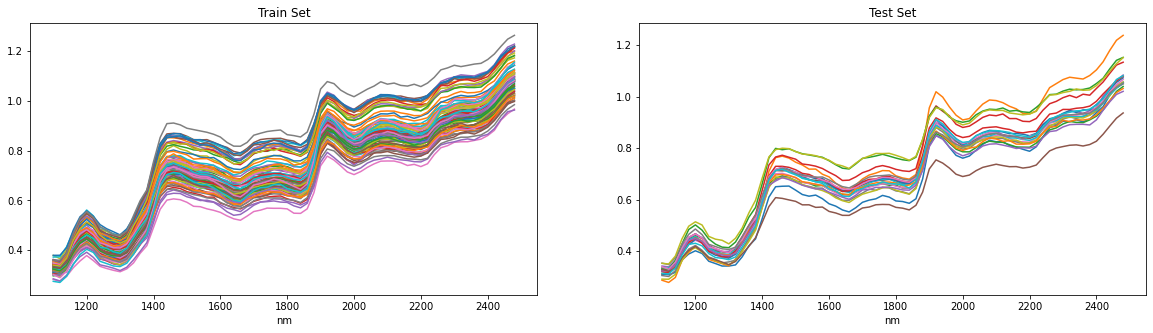

In [4]:
plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplot(121)
for x in range(len(y_train)):
    plt.plot(domain, y_train[x,:])
plt.title('Train Set')
plt.xlabel('nm')

plt.subplot(122)
for x in range(len(y_test)):
    plt.plot(domain, y_test[x,:])
plt.title('Test Set')
plt.xlabel('nm')
plt.show()

## 1) 
Code your own Kernel regression with Epanechnikov kernel and find the optimal bandwidth fitted to the mean signal of the training data. Report the optimal bandwidth and plot the estimated mean function along with the sample average signal.
Epanechnikov kernel is defined as:

\begin{equation}
k(z)=
\begin{cases}
\frac{3}{4}(1-z^2) & if\ |z|\leq 1\\
0\ \ \ \ \ \ \ \ \ \ \text{else}
\end{cases}
\end{equation}



In [5]:
# Epanechnikov kernel function
def ekov(z):
    if np.abs(z) <= 1: return (3.0/4.0)*(1-z**2)
    else: return 0

#### Test kernel function

In [6]:
#Randomly generated data
nonsense = np.linspace(-2,2,1000)

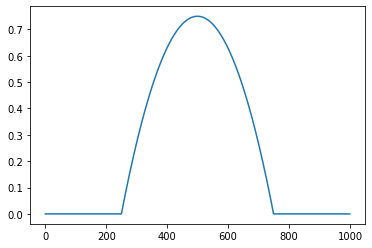

In [7]:
plt.figure()
plt.plot([ekov(x) for x in nonsense])
plt.show()

#### Average traing data

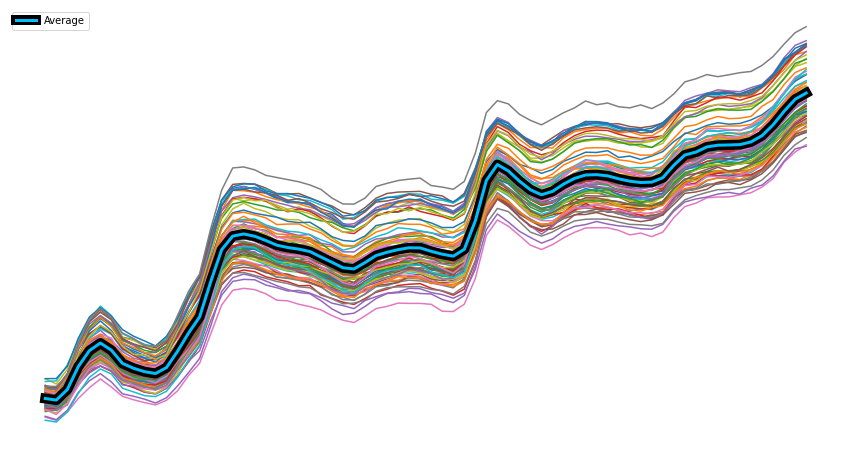

In [8]:
#Average train data
y_train_avg = y_train.mean(axis=0)

plt.figure(figsize=(15,8))
for x in range(len(y_train)):
    plt.plot(y_train[x,:])
plt.plot(y_train_avg,lw=3,color='deepskyblue',path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()], label='Average')
plt.legend()
plt.axis('off')
plt.show()

#### Fit Averaged Data with Epanechnikov kernel and find best LAMDA ($\lambda$) by LOOCV

In [212]:
#Closure function to return prediction function on fitted data
def ekov_fit(x,y,lambda_):

    #return closure function
    def wrapper(x,y,lambda_):
        def inner(xtest):
            if not isinstance(xtest, (list, np.ndarray)):
                xtest = [xtest]
            N = len(xtest)
            f = np.zeros(N)

            for k in range(N):
                #apply Epanechnikov kernel to all values
                z = np.array([ekov(v) for v in ((xtest[k] - x) / lambda_)])
                f[k] = np.sum(z * y) / np.sum(z)

            return f
        return inner
    #establish function call
    func = wrapper(x, y, lambda_)
    
    #return established closure function
    return func

In [10]:
#LOOCV
def epanechnikov_mse_LOOCV(x, y, lambda_):
    '''
    inputs
    ------
    x         -> the independent variable vector
    y         -> the dependent variable vector
    lambda_   -> lambda parameter

    
    returns
    ------
    mse -> the mse for all errors for LOOCV
    '''
    preds = np.zeros(len(y))
    y_true = np.zeros(len(y))
    
    #LOOCV
    for pos, i in enumerate(range(len(y))):
        X = np.delete(x, i)
        Y = np.delete(y, i)
        
        xtest = x[i]
        pred_obj = ekov_fit(x,y,lambda_)
        
        pred = pred_obj(xtest)
        preds[i] = pred
        y_true[i] = y[i]
        
    mse = mean_squared_error(y_true, preds)
    
    
    return mse
    

In [11]:
#scale the domain
scaler = MinMaxScaler()
scaler.fit(domain.reshape(-1,1))
domain_scaled = scaler.transform(domain.reshape(-1,1)).ravel()
print('Domain Min: {}\nDomain Max: {}'.format(domain_scaled.min(), domain_scaled.max()))

Domain Min: 0.0
Domain Max: 1.0


In [12]:
# Different values of lambda to test
lams = np.linspace(0.001,1,1000)

In [13]:
#perform LOOCV
mses = []

for l in lams:
    mses.append(epanechnikov_mse_LOOCV(x=domain_scaled, y=y_train_avg, lambda_=l))

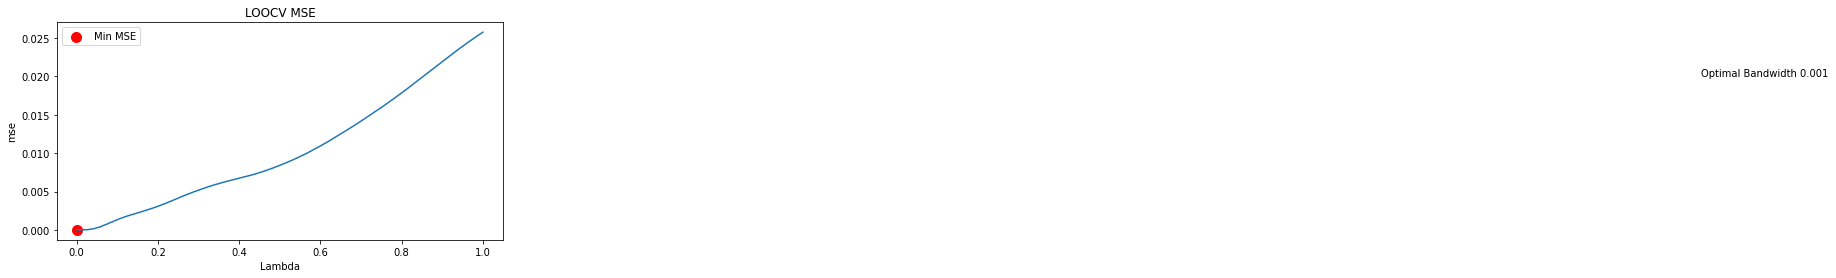

In [14]:
plt.figure(figsize=(8,4))
plt.plot(lams,mses)
plt.scatter(lams[np.argmin(mses)], mses[np.argmin(mses)], color='r', s=100, label='Min MSE')
plt.xlabel('Lambda')
plt.ylabel('mse')
plt.title('LOOCV MSE')
plt.text(4,0.02, 'Optimal Bandwidth {}'.format(lams[np.argmin(mses)]))
plt.legend()
plt.show()

In [15]:
# Create a kernel function with the best found lambda (kernel bandwidth) value
ekov_mapper = ekov_fit(x=domain_scaled, y=y_train_avg, lambda_=lams[np.argmin(mses)])

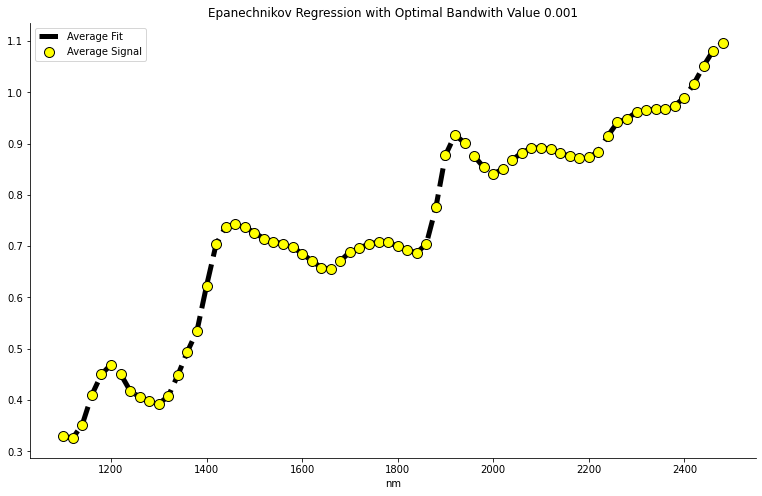

In [16]:
plt.figure(figsize=(13,8))
plt.plot(domain, ekov_mapper(domain_scaled), color = 'k', lw=5, ls='--' ,zorder=1, label='Average Fit')
plt.scatter(domain, y_train_avg, color='yellow', edgecolor='k', s=100, zorder=2, label='Average Signal')
plt.title('Epanechnikov Regression with Optimal Bandwith Value {}'.format(lams[np.argmin(mses)]))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('nm')
plt.legend()
plt.show()

#### Result
The optimal bandwidth when fitting Epanechnikov Regression on the mean signal of the training data was found to be 0.001. This low bandwidth is a cause for concern however as it appears to be a value which induces high variance (extreme overfitting). The level of 0.001 is also due to rescaling the domain from magnitudes of 1100-2500 to 0-1. 

## 2)
Develop a prediction model to predict the protein and moisture content based on the kernel you found in part (1) and the training data.

In [236]:
# Gaussian Kernel on abscissa
H = ekov_mapper(domain_scaled)

In [237]:
#OLS to solve for weights on train set
betas = np.linalg.lstsq(H.T.reshape(-1,1), y_train.T, rcond=None)[0].T

#OLS to solve for weights on test set
betas_test = np.linalg.lstsq(H.T.reshape(-1,1), y_test.T, rcond=None)[0].T

In [248]:
y

(70,)

#### Linear Regression model on weights

In [19]:
#fit a linear regression model on the training weights (independent variable) and the training protein values (dependent variable)
model = LinearRegression()
model.fit(betas, response_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
#predict on the train and test sets
train_preds = model.predict(betas)
test_preds = model.predict(betas_test)

In [21]:
print('Training data MSE: {}'.format(mean_squared_error(response_train, model.predict(betas))))
print('Test data MSE: {}'.format(mean_squared_error(response_test, model.predict(betas_test))))

Training data MSE: 1.0232399728722652
Test data MSE: 1.5184823164384993


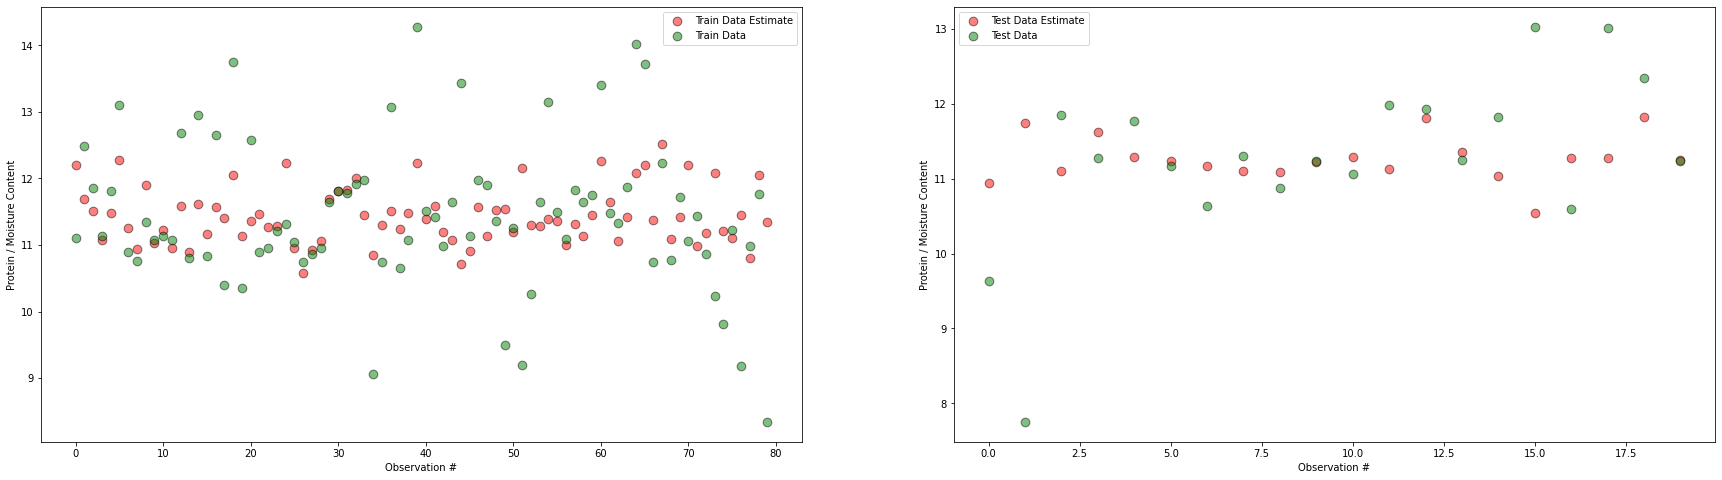

In [22]:
plt.subplots(nrows=1, ncols=2, figsize=(30,8))
plt.subplot(121)
plt.scatter(range(len(train_preds)), train_preds, label='Train Data Estimate', color='red', alpha=0.5, edgecolor='k',s=75)
plt.scatter(range(len(train_preds)), response_train, label='Train Data',color='green', alpha=0.5, edgecolor='k', s=75)
plt.legend()
plt.xlabel('Observation #')
plt.ylabel('Protein / Moisture Content')
plt.subplot(122)
plt.scatter(range(len(test_preds)), test_preds, label='Test Data Estimate', color='red', alpha=0.5, edgecolor='k', s=75)
plt.scatter(range(len(test_preds)), response_test, label='Test Data',color='green', alpha=0.5, edgecolor='k', s=75)
plt.legend()
plt.xlabel('Observation #')
plt.ylabel('Protein / Moisture Content')
plt.show()

## 3)
Find the optimal lambda using GCV for the smoothing splines fitted to the mean signal of the training data. Report the optimal lambda and the number of spline coefficients corresponding to the optimal lambda.        

In [151]:
def smoothing_splines(x, y, spar):
    '''
    inputs
    ------
    x -> independent variables
    y -> dependent variables
    spar -> smoothing parameter
    
    outputs
    -------
    yhat -> the fitted values
    pred_obj -> function used to predict on new unseen data
    
    '''
    
    #get the smooth.spline function used by r
    smooth_spline = robjects.r['smooth.spline']

    #conver x and y to r objects
    x = robjects.FloatVector(list(x))
    y = robjects.FloatVector(list(y))

    #fit the data
    spline_obj = smooth_spline(x=x, y=y, spar=float(spar))
    
    
    '''
    This closure function is returned so predictions can be made on new unseen data.
    '''
    def wrapper(spline_obj):
        def inner(x):
            x = robjects.FloatVector(list(x))
            yspline = robjects.r['predict'](spline_obj,x).rx2('y')
            return np.array(yspline)
        return inner
    
    #create the prediction function
    predict_obj = wrapper(spline_obj)
    
    #return yhat, df, and prediction function
    return np.array(spline_obj.rx2('y')),np.array(spline_obj.rx2('df'))[0] , predict_obj, spline_obj

#### Test out smoothing spline implementation

In [152]:
#arbitrary data to test out smoothing spline implementation
n=100; k=40; x = np.linspace(0,1,n); y=2.5*x-np.sin(10*x)-np.exp(-10*x); sigma=0.3; ynoise = y + np.random.randn(n)*sigma

In [153]:
fit, _, _, _ = smoothing_splines(x,ynoise,0.5)

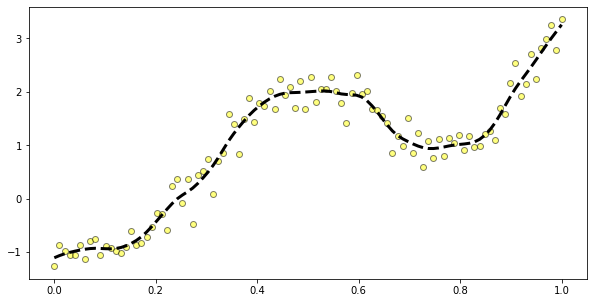

In [154]:
plt.figure(figsize=(10,5))
plt.scatter(x,ynoise,edgecolor='k', alpha=0.5, color='yellow')
plt.plot(x,fit, ls='--', lw=3, color='k')
plt.show()

#### Hyperparameter search across multiple smoothing parameter values

In [155]:
# 1000 smoothing parameters from [0,1]
lams = np.linspace(0,1,2000)

#RSS placeholder
RSS = np.zeros(len(lams))

#df placeholder
dfs = np.zeros(len(lams))

n = len(y_train_avg)

In [156]:
# Hyperparam search across all values of lambda
for pos, l in enumerate(lams):
    yhat, df, _ , _= smoothing_splines(x=domain_scaled, y=y_train_avg, spar=l)
    dfs[pos] = df
    RSS[pos] = np.sum((yhat - y_train_avg)**2)

#### GCV

In [157]:
GCV = (RSS/n)/((1- dfs /n)**2)

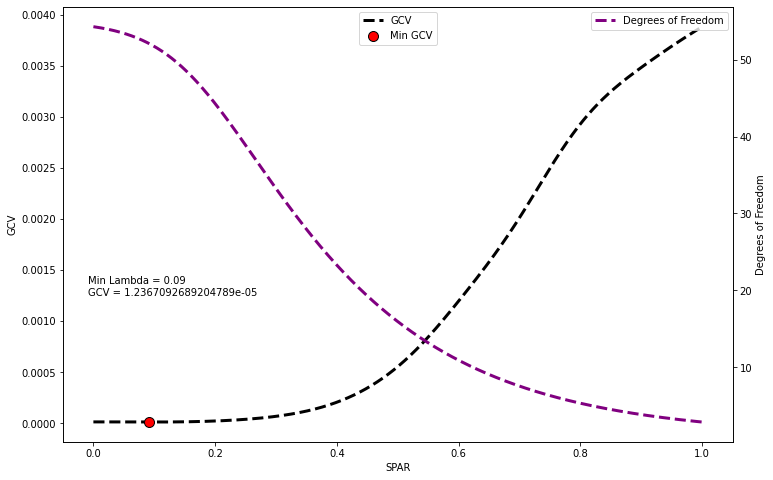

In [196]:
plt.figure(figsize=(12,8))
plt.plot(lams,GCV,zorder=1,color='k', ls='--', label='GCV', lw=3)
plt.scatter(lams[np.argmin(GCV)], GCV[np.argmin(GCV)], color='red', s=100, edgecolor='k', label='Min GCV',zorder=2)
plt.text(lams[np.argmin(GCV)] - 1.1 * lams[np.argmin(GCV)], GCV[np.argmin(GCV)] + 100 * GCV[np.argmin(GCV)], 'Min Lambda = {}\nGCV = {}'.format(round(lams[np.argmin(GCV)],2), GCV[np.argmin(GCV)]))
plt.xlabel('SPAR')
plt.ylabel('GCV')
plt.legend(loc='upper center')
plt.twinx()
plt.plot(lams,dfs,ls='--', lw=3, color='purple', label='Degrees of Freedom')
plt.legend()
plt.ylabel('Degrees of Freedom')
plt.show()

In [252]:
yhat, df, pred , spl = smoothing_splines(x=domain, y=y_train, spar=0.09)

0.09984648973467602
0.11014777349485899
0.09797998796684743
0.06958838110478671
0.07431236864070745
0.08234204795003569
0.09314371367766272
0.08351275114287077
0.09795124568804026
0.08623478871386087
0.0841892583926146
0.10237623114395206
0.07762546359419353
0.07655136095426046
0.08501488670338858
0.07812478043317078
0.10868353963643218
0.08193935560245791
0.10167286233218281
0.07695799866931041
0.09658997425788407
0.07001645007068957
0.08527368110281675
0.07376166938678319
0.12089910519622044
0.11638766884667223
0.07381732687467002
0.065172553681354
0.09172212149972436
0.08979311793776068
0.08097619336066497
0.07804525932648487
0.07122241582961486
0.0882593754293734
0.08082076860880988
0.08977034322611438
0.07825749308577423
0.10218467215542043
0.10000638117638261
0.1196705166626793
0.09377022407726954
0.0819228910925951
0.07180528600177166
0.07434912449086195
0.08376191131005983
0.0676107534010218
0.07723197393472642
0.06674017723962844
0.05954079260664874
0.09512963976257172
0.08174

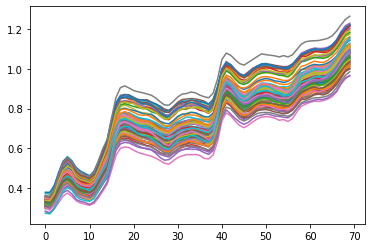

In [259]:
for i in range(y_train.shape[0]):
    yhat, _, _, _ = smoothing_splines(x=domain, y=y_train[i,:], spar = 0.09)
    print(np.sum(np.abs(yhat - y_train[i,:])))
    plt.plot(yhat)
plt.show()

In [254]:
pred(y_train[1,:])

array([0.82929964, 0.82930446, 0.82928918, 0.82926364, 0.82924386,
       0.82923302, 0.82923968, 0.82925723, 0.8292632 , 0.82926675,
       0.82926823, 0.82926511, 0.82924534, 0.82922032, 0.82920124,
       0.82916   , 0.82911439, 0.82909609, 0.8290967 , 0.82909664,
       0.82910298, 0.82910664, 0.82911022, 0.82911495, 0.82911595,
       0.82912505, 0.82912633, 0.82913535, 0.82913753, 0.82912886,
       0.82912057, 0.82911646, 0.8291139 , 0.82911264, 0.82911136,
       0.82911596, 0.82912269, 0.82912351, 0.82911873, 0.82908177,
       0.82903552, 0.8290168 , 0.82902185, 0.82903338, 0.82904634,
       0.82904933, 0.82904341, 0.8290331 , 0.82902726, 0.82902245,
       0.82902244, 0.82902129, 0.82902716, 0.82902872, 0.82903143,
       0.82902904, 0.82902555, 0.82901228, 0.82899643, 0.82899827,
       0.82898951, 0.82898894, 0.82898851, 0.82898845, 0.82898679,
       0.82897798, 0.82896855, 0.82895045, 0.82893636, 0.82892966])

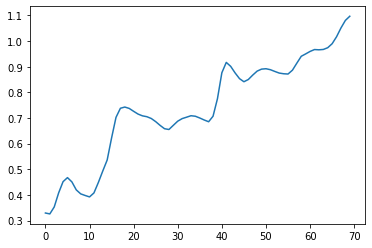

In [255]:
plt.plot(yhat)